# Basic examples

In this notebook we will show how to compute correlation functions with various binning schemes of survey and periodic data, how to dump them to disk, etc.
You need to have installed **pycorr** with:
```
python -m pip install git+https://github.com/cosmodesi/pycorr#egg=pycorr[corrfunc]
```

In [1]:
import os
import tempfile

import numpy as np
from matplotlib import pyplot as plt

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, setup_logging

# To activate logging
setup_logging()

In [2]:
def generate_catalogs(size=10000, boxsize=(1000,)*3, offset=(1000.,0.,0.), n_individual_weights=1, seed=42):
    rng = np.random.RandomState(seed=seed)
    toret = []
    for i in range(2):
        positions = [o + rng.uniform(0., 1., size)*b for o, b in zip(offset, boxsize)]
        weights = [rng.uniform(0.5, 1., size) for i in range(n_individual_weights)]
        toret.append((positions, weights))
    return toret

In [3]:
# First, generate fake data with Cartesian positions and weights
(data_positions1, data_weights1), (data_positions2, data_weights2) = generate_catalogs(size=10000, seed=42)
(randoms_positions1, randoms_weights1), (randoms_positions2, randoms_weights2) = generate_catalogs(size=50000, seed=43)

## High-level interface
Here we use the high-level interface, that will take care of computing pair counts.

### Survey data

For survey data, we will use the Landy-Szalay estimator.

In [4]:
# Compute the s-mu cross-correlation function, with 50 bins between 0 and 100
# and 100 mu-bins between -1 and 1, with 'midpoint' line-of-sight (default), using Corrfunc and 4 OpenMP threads
edges = (np.linspace(0., 100., 51), np.linspace(-1., 1., 201))
result = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     data_positions2=data_positions2, data_weights2=data_weights2,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                                     engine='corrfunc', nthreads=4)

[000000.05]  03-09 19:25  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000000.05]  03-09 19:25  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000002.49]  03-09 19:25  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000004.56]  03-09 19:25  TwoPointCorrelationFunction  INFO     Computing two-point counts R1D2.
[000006.17]  03-09 19:25  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.


In [5]:
# s, mu and weighted counts can be obtained through:
print(result.sep.shape, result.seps[1].shape, result.corr.shape)

(50, 200) (50, 200) (50, 200)


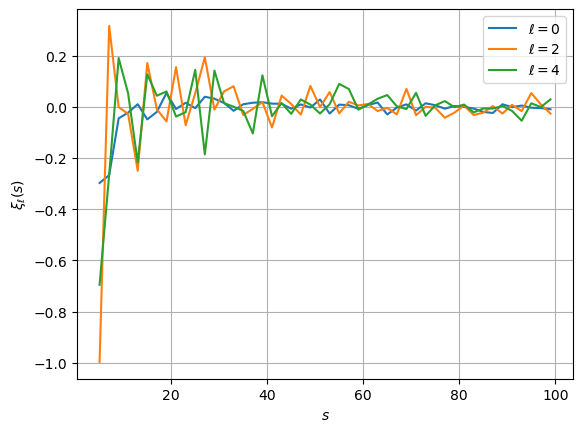

In [6]:
# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
s, xiell = result(ells=ells, return_sep=True)
ax = plt.gca()
for ill, ell in enumerate(ells):
    ax.plot(s, xiell[ill], label='$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$\xi_{\ell}(s)$')
plt.show()
# Zero correlation, as expected

In [7]:
# You can save the result
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    result.save(fn)
    # And reload the result
    #result = TwoPointEstimator.load(fn)
    result = TwoPointCorrelationFunction.load(fn)
    print(result.D1D2.autocorr)

# You can also export correlation function multipoles as .txt
# WARNING: this does not save all attributes, so there is not load_txt method
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.txt')
    # See get_corr() for all arguments
    result.save_txt(fn, header=['data_file1 = data1.fits', 'data_file2 = data2.fits'], ells=(0, 2, 4))
    with open(fn, 'r') as file:
        for iline in range(30):
            print(next(file)[:-1])
    tmp = np.loadtxt(fn, unpack=True)
    assert np.allclose(tmp[2], result(ells=0), equal_nan=True)

[000009.77]  03-09 19:25  LandySzalayTwoPointEstimator INFO     Saving /tmp/tmps5t9vcls/tmp.npy.
[000009.77]  03-09 19:25  TwoPointEstimator            INFO     Loading /tmp/tmps5t9vcls/tmp.npy.
False
[000009.78]  03-09 19:25  LandySzalayTwoPointEstimator INFO     Saving /tmp/tmpi46yemyz/tmp.txt.
# data_file1 = data1.fits
# data_file2 = data2.fits
# mode = smu
# autocorr = False
# D1D2.size1 = 10000
# D1D2.size2 = 10000
# D1D2.wnorm = 5.617269471435e+07
# D1R2.size1 = 10000
# D1R2.size2 = 50000
# D1R2.wnorm = 2.808116579539e+08
# R1D2.size1 = 50000
# R1D2.size2 = 10000
# R1D2.wnorm = 2.807847234976e+08
# R1R2.size1 = 50000
# R1R2.size2 = 50000
# R1R2.wnorm = 1.403664612041e+09
# los_type = midpoint
# bin_type = lin
# smid             savg               corr0(s)            corr2(s)            corr4(s)
1.000000000000e+00 1.515350414542e+00 nan                 nan                 nan
3.000000000000e+00 3.212309768753e+00 nan                 nan                 nan
5.000000000000e+00 5.104

In [8]:
# You can reuse a precomputed R1R2 result.R1R2
result2 = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                      data_positions2=data_positions2, data_weights2=data_weights2,
                                      randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                      randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                                      engine='corrfunc', R1R2=result.R1R2, nthreads=4)

mask = np.isfinite(result.corr)
assert np.allclose(result2.corr[mask], result.corr[mask])

[000009.82]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000009.82]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000011.83]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000014.42]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts R1D2.
[000016.81]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using precomputed two-point counts R1R2.


### Line-of-sight

In [9]:
# By default (above), line-of-sight is 'midpoint'
# Compute the s-mu auto-correlation function, using x as line-of-sight
edges = (np.linspace(0., 100., 51), np.linspace(-1., 1., 201))
result = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     los='x', engine='corrfunc', nthreads=4)

# Compute the s-mu cross-correlation function, using 'firstpoint' line-of-sight (only available for smu)
edges = (np.linspace(0., 100., 51), np.linspace(-1., 1., 201))
result = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     data_positions2=data_positions2, data_weights2=data_weights2,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                                     los='firstpoint', engine='corrfunc', nthreads=4)

# Compute the s-mu cross-correlation function, using 'firstpoint' line-of-sight (only available for smu)
edges = (np.linspace(0., 100., 51), np.linspace(-1., 1., 201))
result = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     data_positions2=data_positions2, data_weights2=data_weights2,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                                     los='endpoint', engine='corrfunc', nthreads=4)

[000016.83]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000016.83]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000017.56]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000019.27]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000020.93]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000020.95]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000022.74]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000025.24]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts R1D2.
[000027.62]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000029.84]  03-09 19:26  Two

[000039.41]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000039.42]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000039.81]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000040.23]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts R1D2.
[000040.77]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.


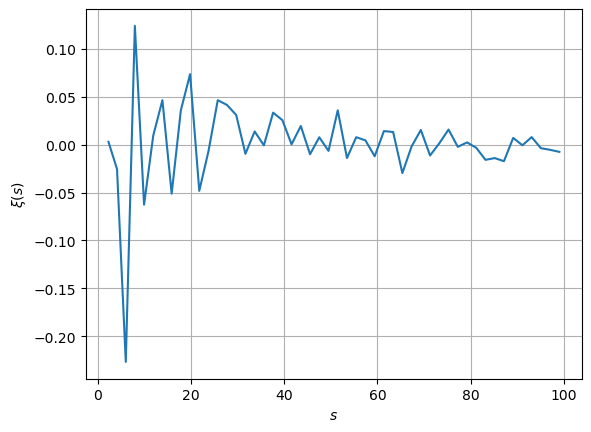

In [10]:
# Other binning are "s", "rppi"
edges = np.linspace(1., 100., 51)
result = TwoPointCorrelationFunction('s', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     data_positions2=data_positions2, data_weights2=data_weights2,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                                     engine='corrfunc', nthreads=4)
ax = plt.gca()
ax.plot(result.sep, result.corr)
ax.set_xlabel('$s$')
ax.set_ylabel(r'$\xi(s)$')
ax.grid(True)
plt.show()

[000041.84]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000041.84]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000042.11]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000042.71]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.


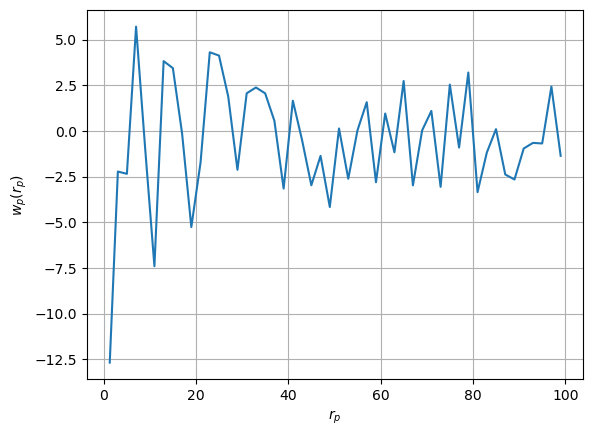

In [11]:
# Here we compute rp-pi auto-correlation
edges = (np.linspace(0., 100., 51), np.linspace(0, 40, 41))
result = TwoPointCorrelationFunction('rppi', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     engine='corrfunc', nthreads=4)
ax = plt.gca()
sep, wp = result(pimax=None, return_sep=True)
ax.plot(sep, wp)
ax.set_xlabel('$r_{p}$')
ax.set_ylabel(r'$w_{p}(r_{p})$')
ax.grid(True)
plt.show()

[000043.25]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000043.25]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000043.32]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000043.79]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.


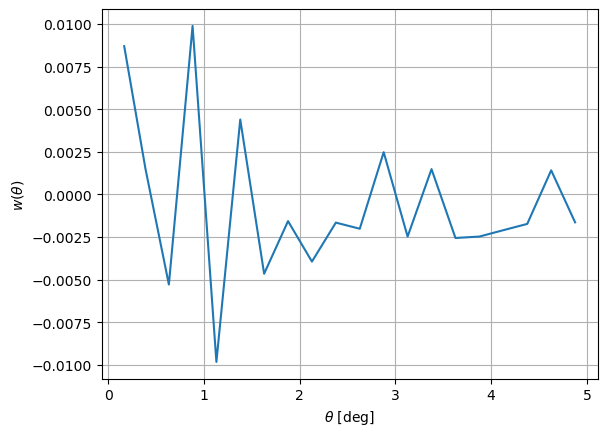

In [12]:
# Here we compute angular auto-correlation, without weights
# we provide cartesian positions instead of RA/Dec, so say position_type='xyz'
edges = np.linspace(0., 5., 21)
result = TwoPointCorrelationFunction('theta', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     engine='corrfunc', position_type='xyz', nthreads=4)
ax = plt.gca()
ax.plot(result.sep, result.corr)
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$w(\theta)$')
ax.grid(True)
plt.show()

[000046.44]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000046.45]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000046.64]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000047.82]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000050.65]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000050.65]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000050.81]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000053.61]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.DavisPeeblesTwoPointEstimator'>.
[000053.61]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-po

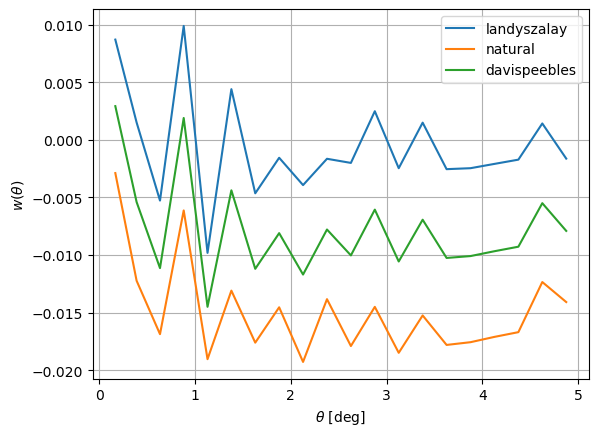

In [13]:
# Here we test different estimators
edges = np.linspace(0., 5., 21)
kwargs = dict(engine='corrfunc', position_type='xyz', nthreads=4)
result_szalay = TwoPointCorrelationFunction('theta', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                            randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                            estimator='landyszalay', **kwargs)
result_natural = TwoPointCorrelationFunction('theta', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                             randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                             estimator='natural', **kwargs)
result_davispeebles = TwoPointCorrelationFunction('theta', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                             randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                             estimator='davispeebles', **kwargs)
ax = plt.gca()
ax.plot(result.sep, result_szalay.corr, label='landyszalay')
ax.plot(result.sep, result_natural.corr, label='natural')
ax.plot(result.sep, result_davispeebles.corr, label='davispeebles')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$w(\theta)$')
ax.grid(True)
ax.legend()
plt.show()

[000055.49]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000055.50]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000056.73]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1S2.
[000058.42]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts S1D2.
[000060.98]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts S1S2.
[000064.30]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.


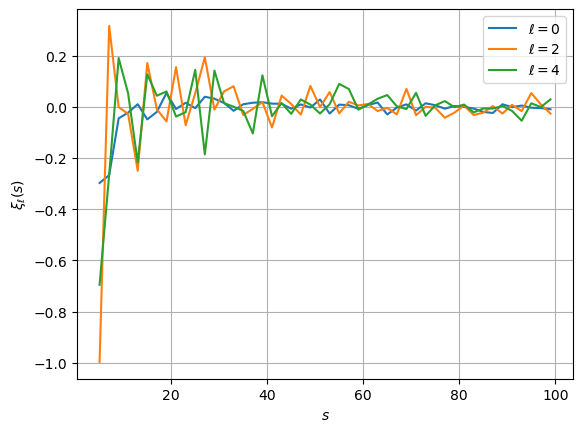

In [14]:
# In case of reconstruction, using shifted catalogs random catalogs (here we just use the same)
# This will compute (D1D2 - D1S2 - S1D2 - S1S2)/R1R2
shifted_positions1, shifted_weights1 = randoms_positions1, randoms_weights1
shifted_positions2, shifted_weights2 = randoms_positions2, randoms_weights2
edges = (np.linspace(0., 100., 51), np.linspace(-1., 1., 201))
result = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     data_positions2=data_positions2, data_weights2=data_weights2,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                                     shifted_positions1=shifted_positions1, shifted_weights1=shifted_weights1,
                                     shifted_positions2=shifted_positions2, shifted_weights2=shifted_weights2,
                                     engine='corrfunc', nthreads=4)

# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
s, xiell = result(ells=ells, return_sep=True)
ax = plt.gca()
for ill, ell in enumerate(ells):
    ax.plot(s, xiell[ill], label='$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel('$s$')
ax.set_ylabel(r'$\xi_{\ell}(s)$')
plt.show()
# Flat, as expected

### Periodic box data

For periodic box data, we will use the natural estimator. Syntax with the high-level interface is the same.

[000067.92]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000067.92]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000067.95]  03-09 19:26  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.
[000067.98]  03-09 19:26  matplotlib.legend            WARNING  No handles with labels found to put in legend.


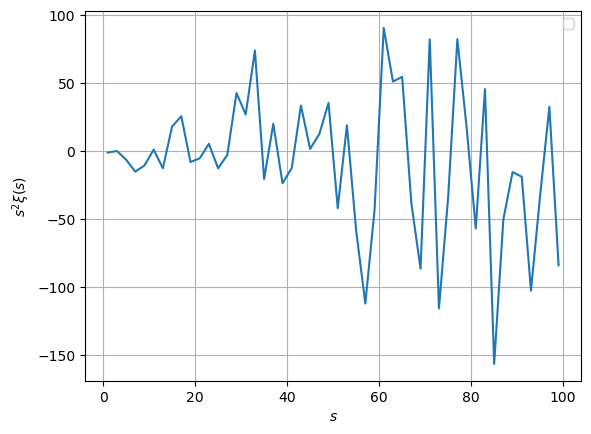

In [15]:
# Compute the s-correlation function, with 50 bins between 0 and 100
edges = np.linspace(0., 100., 51)
boxsize = 1000.
result = TwoPointCorrelationFunction('s', edges, data_positions1=data_positions1,
                                     engine='corrfunc', boxsize=boxsize, nthreads=4,
                                     compute_sepsavg=False) # we do not ask for average sep

# Let us project to multipoles (monopole, quadruple, hexadecapole)
ax = plt.gca()
ax.plot(result.sep, result.sep**2*result.corr)
ax.legend()
ax.set_xlabel('$s$')
ax.set_ylabel(r'$s^{2}\xi(s)$')
ax.grid(True)
plt.show()
# Flat, as expected

[000068.17]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000068.17]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000068.37]  03-09 19:26  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.


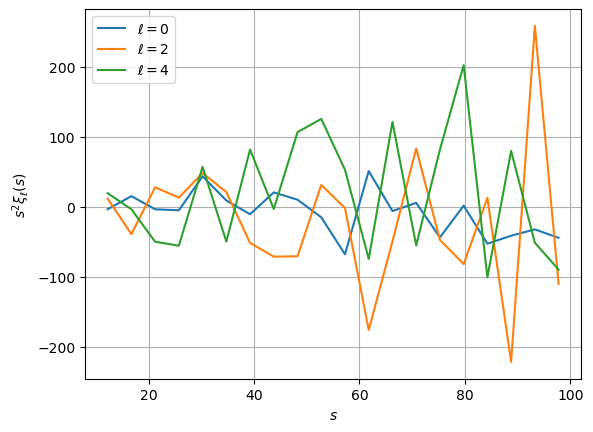

In [16]:
# Compute the s-mu correlation function, with 50 bins between 0 and 100
# and 100 mu-bins between -1 and 1, using Corrfunc and 4 OpenMP threads
edges = (np.linspace(10., 100., 21), np.linspace(-1., 1., 201))
boxsize = 1000.
result = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1,
                                     engine='corrfunc', boxsize=boxsize, los='z', nthreads=4)

# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
s, xiell = result(ells=ells, return_sep=True)
ax = plt.gca()
for ill, ell in enumerate(ells):
    ax.plot(s, s**2*xiell[ill], label='$\ell = {:d}$'.format(ell))
ax.legend()
ax.set_xlabel('$s$')
ax.set_ylabel(r'$s^{2}\xi_{\ell}(s)$')
ax.grid(True)
plt.show()
# Flat, as expected

## Two-point counters

Same results can be obtained directly from pair counters, e.g. for the last correlation function estimation.

In [17]:
from pycorr import TwoPointCounter, AnalyticTwoPointCounter, NaturalTwoPointEstimator
edges = (np.linspace(10., 100., 21), np.linspace(-1., 1., 201))
D1D2 = TwoPointCounter('smu', edges, positions1=data_positions1,
                       engine='corrfunc', boxsize=boxsize, los='z', nthreads=4)
R1R2 = AnalyticTwoPointCounter('smu', edges, boxsize=boxsize)

# You can save the result
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    D1D2.save(fn)
    # And reload the result
    D1D2 = TwoPointCounter.load(fn)

# You can also export pair counts as .txt (WARNING: this does not save all attributes, so there is not load_txt method)
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.txt')
    # See get_corr() for all arguments
    D1D2.save_txt(fn, header=['data_file1 = data1.fits', 'data_file2 = data2.fits'])
    with open(fn, 'r') as file:
        for iline in range(30):
            print(next(file)[:-1])
    tmp = np.loadtxt(fn, unpack=True)
    assert np.allclose(tmp[4], D1D2.wcounts.flat)

result2 = NaturalTwoPointEstimator(D1D2=D1D2, R1R2=R1R2)
mask = np.isfinite(result.corr)
assert np.allclose(result2.corr[mask], result.corr[mask])

[000068.86]  03-09 19:26  CorrfuncTwoPointCounter      INFO     Saving /tmp/tmp1h1d1kxi/tmp.npy.
[000068.86]  03-09 19:26  TwoPointCounter              INFO     Loading /tmp/tmp1h1d1kxi/tmp.npy.
[000068.87]  03-09 19:26  CorrfuncTwoPointCounter      INFO     Saving /tmp/tmpeos7lx6g/tmp.txt.
# data_file1 = data1.fits
# data_file2 = data2.fits
# mode = smu
# autocorr = True
# size1 = 10000
# size2 = 10000
# wnorm = 99990000
# los_type = z
# bin_type = lin
# smid             savg               mumid               muavg               wcounts
1.225000000000e+01 1.368951805934e+01 -9.950000000000e-01 -9.950000000000e-01 4
1.225000000000e+01 1.292670170575e+01 -9.850000000000e-01 -9.850000000000e-01 3
1.225000000000e+01 1.329794038322e+01 -9.750000000000e-01 -9.750000000000e-01 5
1.225000000000e+01 1.297076548035e+01 -9.650000000000e-01 -9.650000000000e-01 2
1.225000000000e+01 1.320390884935e+01 -9.550000000000e-01 -9.550000000000e-01 4
1.225000000000e+01 1.296981360158e+01 -9.450000000000e-0

## Rebinning
We provide methods to rebin correlation function estimation accurately, i.e. doing this for all pair counts.

In [18]:
result2 = result[::2,::4]
print('Initially {:d} sep, {:d} mu.'.format(len(result.seps[0]), len(result.seps[1])))
print('After rebinning {:d} sep, {:d} mu.'.format(len(result2.seps[0]), len(result2.seps[1])))
# The same method exists for pair counts
# Note that you can remove some bins such that the rebinning factor divides the shape
# Here we remove the two last bins of the first axis before rebinning
D1D2 = result.D1D2[:-2:6,::1]
# You can also select some range
sep, mu = result2.sepavg(axis=0), result2.sepavg(axis=1)
print('Initially sep in [{}, {}], mu in [{}, {}].'.format(sep.min(), sep.max(), mu.min(), mu.max()))
result2.select((0, 30.), (0., 0.5))
sep, mu = result2.sepavg(axis=0), result2.sepavg(axis=1)
print('After selection sep in [{}, {}], mu in [{}, {}].'.format(sep.min(), sep.max(), mu.min(), mu.max()))

Initially 20 sep, 20 mu.
After rebinning 10 sep, 10 mu.
Initially sep in [14.5, 95.5], mu in [-0.98, 0.98].
After selection sep in [14.5, 23.5], mu in [0.020000000000000018, 0.5].


## Speeding up calculation
As demonstrated in https://arxiv.org/pdf/1905.01133.pdf, "splitting the random catalog into a
number of subcatalogs of the same size as the data catalog when calculating random - random pairs and excluding pairs  across different subcatalogs provides the optimal error at fixed computational cost".

In [19]:
edges = (np.linspace(0., 100., 41), np.linspace(-1., 1., 201))

size_randoms = len(randoms_positions1[0])
nsplits = size_randoms//len(data_positions1[0])
D1D2 = None
split = 0
for isplit in range(nsplits):
    print('Split {:d}/{:d}.'.format(isplit+1, nsplits))
    sl = slice(isplit*size_randoms//nsplits, (isplit+1)*size_randoms//nsplits)
    split += TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                         randoms_positions1=[p[sl] for p in randoms_positions1], randoms_weights1=[w[sl] for w in randoms_weights1],
                                         los='midpoint', engine='corrfunc', position_type='xyz', D1D2=D1D2, nthreads=4)
    D1D2 = split.D1D2 # D1D2 is passed to next computation, which avoids recomputing it again
# Note: in the sum split += TwoPointCorrelationFunction(...), individual counts get summed over in the same way as:
R1R2 = sum(TwoPointCounter('smu', edges, positions1=[p[sl] for p in randoms_positions1], weights1=[w[sl] for w in randoms_weights1],
                           los='midpoint', engine='corrfunc', position_type='xyz', nthreads=4)
                           for sl in (slice(isplit*size_randoms//nsplits, (isplit+1)*size_randoms//nsplits) for isplit in range(nsplits)))
assert np.allclose(R1R2.wcounts, split.R1R2.wcounts)
# Just for the comparison plot
ref = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                  randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                  los='midpoint', engine='corrfunc', position_type='xyz', nthreads=4)

Split 1/5.
[000069.45]  03-09 19:26  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000069.45]  03-09 19:26  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000070.37]  03-09 19:27  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000072.13]  03-09 19:27  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
Split 2/5.
[000073.13]  03-09 19:27  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000073.13]  03-09 19:27  TwoPointCorrelationFunction  INFO     Using precomputed two-point counts D1D2.
[000073.14]  03-09 19:27  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000074.83]  03-09 19:27  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
Split 3/5.
[000075.56]  03-09 19:27  TwoPointCorrelationFunction  INFO     Using estimator <clas

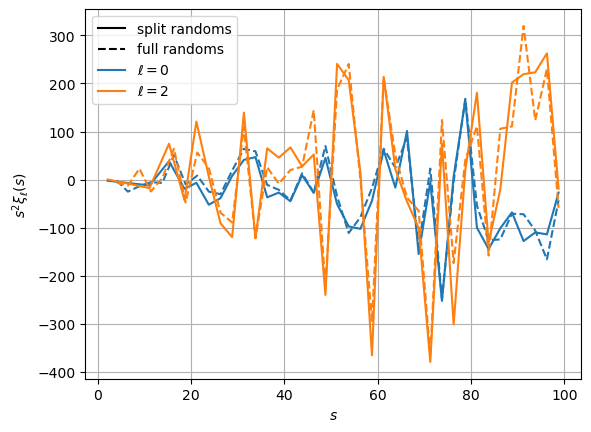

In [20]:
ells = (0, 2)
ax = plt.gca()
ax.plot([], [], linestyle='-', color='k', label='split randoms')
ax.plot([], [], linestyle='--', color='k', label='full randoms')
for ill, ell in enumerate(ells):
    s, xiell = split(ells=ell, return_sep=True)
    ax.plot(s, s**2*xiell, color='C{:d}'.format(ill), linestyle='-', label='$\ell = {:d}$'.format(ell))
    s, xiell = ref(ells=ell, return_sep=True)
    ax.plot(s, s**2*xiell, color='C{:d}'.format(ill), linestyle='--', label=None)
ax.legend()
ax.set_xlabel('$s$')
ax.set_ylabel(r'$s^{2}\xi_{\ell}(s)$')
ax.grid(True)
ax.legend()
plt.show()

As advocated in in https://arxiv.org/pdf/1905.01133.pdf, when the amplitude of the correlation function is high, randoms should be of higher density. This can be achieved in the following way:

In [21]:
randoms_positions1, randoms_weights1 = generate_catalogs(size=100000, seed=43)[0] # increased density
# Here we also change the bin size; on could even opt e.g. for log binning
edges = (np.linspace(0., 10., 21), np.linspace(-1., 1., 201))
small = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                    randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                    los='midpoint', engine='corrfunc', position_type='xyz', nthreads=4)
combined = small.concatenate_x(small, ref)

[000091.59]  03-09 19:27  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000091.59]  03-09 19:27  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000092.42]  03-09 19:27  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000093.90]  03-09 19:27  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.


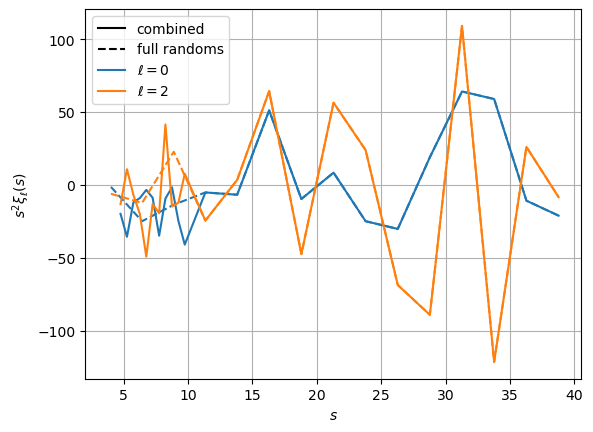

In [22]:
ells = (0, 2)
ax = plt.gca()
ax.plot([], [], linestyle='-', color='k', label='combined')
ax.plot([], [], linestyle='--', color='k', label='full randoms')
for ill, ell in enumerate(ells):
    s, xiell = combined(ells=ell, return_sep=True)
    mask = s < 40.
    ax.plot(s[mask], s[mask]**2*xiell[mask], color='C{:d}'.format(ill), linestyle='-', label='$\ell = {:d}$'.format(ell))
    s, xiell = ref(ells=ell, return_sep=True)
    mask = s < 40.
    ax.plot(s[mask], s[mask]**2*xiell[mask], color='C{:d}'.format(ill), linestyle='--', label=None)
ax.legend()
ax.set_xlabel('$s$')
ax.set_ylabel(r'$s^{2}\xi_{\ell}(s)$')
ax.grid(True)
ax.legend()
plt.show()